In [1]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from model_spec import model_spec
from pol_model import load_bands, model_p, get_a_b
from draine_dust_2D import draine_dust
from scipy.optimize import minimize, LinearConstraint

In [2]:
#The measured values in each band. 
p_measured = np.array([0.0973, 0.1085, 0.1466])
p_unc = np.array([0.0037, 0.0023, 0.0041])

In [3]:
def pol_plot(p_measured, p_unc, mod_p, spec):
    wave = np.array([5500., 6500., 8000.]) / spec.zspec
    plt.errorbar(wave, p_measured, yerr=p_unc, fmt='o', label='Measurements')
    plt.plot(wave, mod_p, 'ks', label='Dust SMC')
    plt.legend()
    plt.xlabel('Wavelength (Angstroms)')
    plt.ylabel('Polarization fraction')
    plt.show()

## Model the SDSS Spectrum

In [4]:
spec, model = model_spec()

In [5]:
#Assume that Lyman alpha is also polarized in the same manner as all the other emission lines. 
model.multi_line[0].pol = True
model.multi_line[1].pol = True

## Model the Broad-band polarizations

In [6]:
bands = load_bands()

In [7]:
def chi2(x, dust, spec):
    phi = x[3]
    theta = np.abs(dust.pfrac(spec.lam_rest.to(u.um).value, phi).flatten())
    a, b = get_a_b(theta, theta, bands, spec, model)
    p_mod = np.zeros(3)
    for j in range(3):
        p_mod[j] = model_p(x[:3], a[j], b[j])
    return np.sum(((p_measured-p_mod)/p_unc)**2)

In [8]:
dust_types = ["SMC", "LMC", "MW"]
mod_p = np.zeros((len(dust_types),len(bands)))
for k, dust_type in enumerate(dust_types):

    dust = draine_dust(type=dust_type)

    #The code has difficulties converging above and below 90 deg. So let's try both and save the best.
    for i in range(2):
        x0 = np.array([0.5, 1.0, 50., 60.])
        if i==1:
            x0[-1] = 170.
        G = np.identity(x0.shape[0])
        min_vals = [0., 0., 0., 0.]
        max_vals = [1., 1., 360., 180.]
        lincon = LinearConstraint(G, min_vals, max_vals)
        xopt_aux = minimize(chi2, x0=x0, constraints=lincon, args=(dust, spec))
        if i==0 or xopt_aux.fun < xopt.fun:
            xopt = xopt_aux

    print(xopt)

    phi = xopt.x[3]
    theta = np.abs(dust.pfrac(spec.lam_rest.to(u.um).value, phi).flatten())
    a, b = get_a_b(theta, theta, bands, spec, model)

    for j in range(len(bands)):
        mod_p[k,j] = model_p(xopt.x[:3], a[j], b[j])
        print(mod_p[k,j])

    #pol_plot(p_measured, p_unc, mod_p, spec)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 11.903341926844046
       x: [ 1.000e+00 -5.322e-11  5.365e+01  1.405e+02]
     nit: 7
     jac: [-2.730e+02  9.526e+00  0.000e+00 -3.099e-06]
    nfev: 33
    njev: 6
0.09733229902696978
0.10718334990756578
0.1326506218674162
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 3.360515933234101e-07
       x: [ 8.892e-01  1.707e-01  7.984e+01  1.276e+02]
     nit: 11
     jac: [-2.552e-02 -1.916e-02 -5.879e-05 -1.316e-03]
    nfev: 62
    njev: 11
0.09730088865238094
0.1084999764465823
0.14659783722742561
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 22.381551890369145
       x: [ 1.000e+00  1.000e+00  8.133e+01  7.821e+01]
     nit: 23
     jac: [-2.158e+02 -3.451e+01 -8.163e-04  1.247e-04]
    nfev: 121
    njev: 23
0.0967047658412802
0.10970594504165736
0.1273340324532872


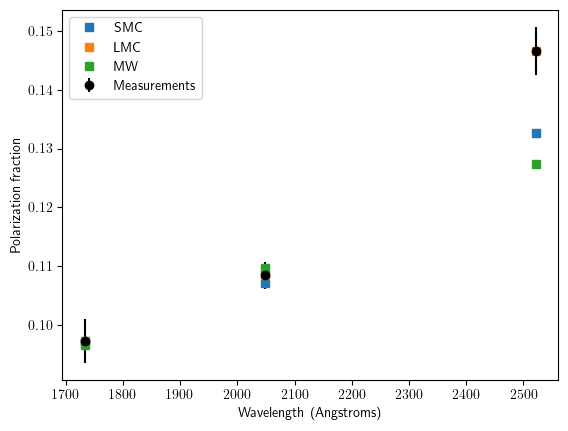

In [9]:
wave = np.array([5500., 6500., 8000.]) / spec.zspec

fig, ax = plt.subplots(1)

ax.errorbar(wave, p_measured, yerr=p_unc, fmt='ko', label='Measurements')
for k, dust_type in enumerate(dust_types):
    ax.plot(wave, mod_p[k], 's', label=dust_type)
ax.legend()
ax.set_xlabel('Wavelength (Angstroms)')
ax.set_ylabel('Polarization fraction')
plt.show()

### Dust for continuum and Gas for Broad Lines.

In [10]:
def chi2(x, dust, spec):
    phi = x[3]
    theta_A = np.abs(dust.pfrac(spec.lam_rest.to(u.um).value, phi).flatten())
    theta_B = np.ones(len(spec.lam_rest))
    a, b = get_a_b(theta_A, theta_B, bands, spec, model)
    p_mod = np.zeros(3)
    for j in range(3):
        p_mod[j] = model_p(x[:3], a[j], b[j])
    return np.sum(((p_measured-p_mod)/p_unc)**2)

In [11]:
dust_types = ["SMC", "LMC", "MW"]
mod_p = np.zeros((len(dust_types),len(bands)))
for k, dust_type in enumerate(dust_types):

    dust = draine_dust(type=dust_type)

    #The code has difficulties converging above and below 90 deg. So let's try both and save the best.
    for i in range(2):
        x0 = np.array([0.5, 1.0, 50., 60.])
        if i==1:
            x0[-1] = 170.
        G = np.identity(x0.shape[0])
        min_vals = [0., 0., 0., 0.]
        max_vals = [1., 1., 360., 180.]
        lincon = LinearConstraint(G, min_vals, max_vals)
        xopt_aux = minimize(chi2, x0=x0, constraints=lincon, args=(dust, spec))
        if i==0 or xopt_aux.fun < xopt.fun:
            xopt = xopt_aux
    print(xopt)

    phi = xopt.x[3]
    theta_A = np.abs(dust.pfrac(spec.lam_rest.to(u.um).value, phi).flatten())
    theta_B = np.ones(len(spec.lam_rest))
    a, b = np.abs(get_a_b(theta_A, theta_B, bands, spec, model))

    for j in range(len(bands)):
        mod_p[k,j] = model_p(xopt.x[:3], a[j], b[j])
        print(mod_p[k,j])

    #pol_plot(p_measured, p_unc, mod_p, spec)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 11.903342511475861
       x: [ 1.000e+00 -2.528e-10  7.036e+01  1.405e+02]
     nit: 9
     jac: [-2.730e+02  1.173e+02  0.000e+00 -8.821e-06]
    nfev: 42
    njev: 8
0.09733231488178562
0.1071833625702602
0.1326506177622731
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1.4652535162669993e-07
       x: [ 9.111e-01  7.636e-02  7.549e+01  1.268e+02]
     nit: 11
     jac: [-4.915e-02  7.464e-02  1.651e-04  1.861e-04]
    nfev: 60
    njev: 11
0.09729900058685946
0.10849984991229387
0.1465989206267433
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 84.09188914565664
       x: [ 1.000e+00 -1.423e-09  3.423e+02  4.806e+01]
     nit: 11
     jac: [-2.513e+02  8.211e+02  0.000e+00  5.436e-04]
    nfev: 38
    njev: 7
0.1113191897059734
0.10796955230098143
0.11237484531854981


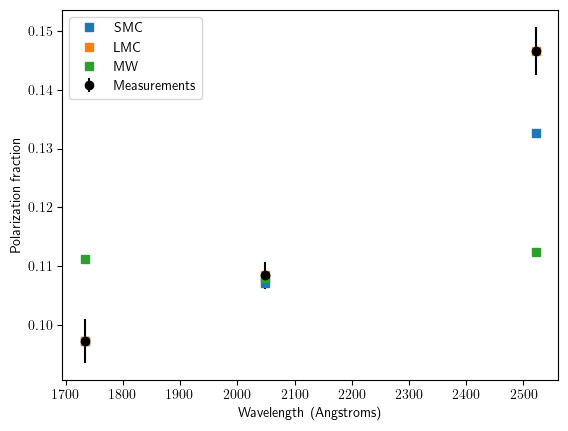

In [12]:
wave = np.array([5500., 6500., 8000.]) / spec.zspec

fig, ax = plt.subplots(1)

ax.errorbar(wave, p_measured, yerr=p_unc, fmt='ko', label='Measurements')
for k, dust_type in enumerate(dust_types):
    ax.plot(wave, mod_p[k], 's', label=dust_type)
ax.legend()
ax.set_xlabel('Wavelength (Angstroms)')
ax.set_ylabel('Polarization fraction')
plt.show()